In [19]:
import os 
import glob
import numpy as np
import rasterio as rio
import pandas as pd
import json
import pyproj
from rasterio import plot
from rasterio.mask import raster_geometry_mask
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform

In [37]:
# Clip all images to the desired aoi.

def clip_to_aoi(path_to_aoi, img_path_list):
    '''This function clips images to an area of interest.
    Inputs:
    path_to_aoi: the absolute path to a geojson file for the aoi
    img_path_list: list of absolute path names for the images to clip.
    
    Output: saves the clipped images as .tif files to the same directory where the original images are stored'''
    
    with open(path_to_aoi, 'r') as f:
        aoi = json.load(f)
    aoi_geom = aoi['features'][0]['geometry']
    
    # find the coordinate reference system of the image
    for i in img_path_list:
        with rio.open(i) as src:
            dst_crs = src.crs
            wgs84 = pyproj.CRS('EPSG:4326')
            project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
            proj_aoi = transform(project, shape(aoi_geom))
            
            mask, mask_transform = rio.mask.mask(src, [proj_aoi], crop=True)
            mask_meta = src.meta
            mask_meta.update({"driver": "GTiff",
                 "height": mask.shape[1],
                 "width": mask.shape[2],
                 "transform": mask_transform})
        
        with rio.open(str(os.path.abspath(i).split('.tif')[0])+".masked.tif", "w", **mask_meta) as dest:
            dest.write(mask)   

In [38]:
img_path_list = glob.glob('../data/images/2020/SkySat/C*/*corg_cor.tif')

In [39]:
img_path_list

['../data/images/2020/SkySat/Coregistered_Scenes/20200812_153924_ssc3d2_0013_analytic_SR_corg_cor.tif',
 '../data/images/2020/SkySat/Coregistered_Scenes/20200805_154044_ssc13d2_0013_analytic_SR_corg_cor.tif',
 '../data/images/2020/SkySat/Coregistered_Scenes/20200618_160058_ssc3d2_0013_analytic_SR_corg_cor.tif',
 '../data/images/2020/SkySat/Coregistered_Scenes/20200710_155028_ssc3d2_0012_analytic_SR_corg_cor.tif',
 '../data/images/2020/SkySat/Coregistered_Scenes/20200625_154704_ssc12d2_0013_analytic_SR_corg_cor.tif']

In [40]:
path_to_aoi = '../data/crittenden.geojson'

In [41]:
#clip_to_aoi(path_to_aoi, img_path_list)

In [58]:
# Try clipping using a multipolygon geojson

def clip_to_multi_aoi(mask_path, rast_path):
    
    '''This function clips images to a multipolygon area of interest.
    
    Inputs:
    mask_path: path to a geojson file for the aoi (can be a multipolygon geometry)
    rast_path: path to the image to clip
    
    Output: saves the clipped image as new .tif file'''
    
    # Read aoi mask and update crs to match image 
    with rio.open(rast_path) as src:
        geo = gpd.read_file(mask_path)
        geo = geo.to_crs(src.crs)
    
        # Mask pixels outside the aoi
        # For more on the rasterio mask function: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html
        
        out_image, out_transform = rio.mask.mask(src, geo.geometry, filled = True)
        show(out_image)
        
        # Update output image metadata to match input image metadata
        mask_meta = src.meta
        mask_meta.update({"driver": "GTiff",
                          "height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})
        
        # Change this depending on preferred output location
        with rio.open('/Users/kathleenkanaley/Desktop/grapes_from_space/data/images/2020/SkySat/'+
                      str(os.path.basename(rast_path).split('.tif')[0])+
                      ".panels.tif", 
                      "w", 
                      **mask_meta) as dest:
            dest.write(out_image)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


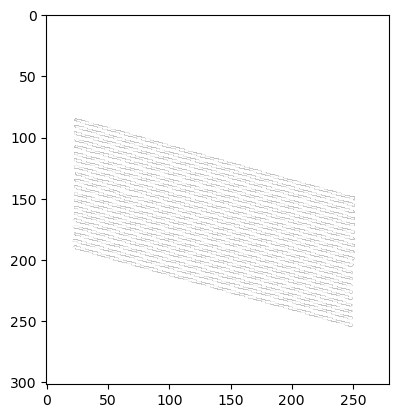

In [59]:
rast_path = '../data/images/2020/SkySat/Coregistered_Scenes/20200618_160058_ssc3d2_0013_analytic_SR_corg_cor.masked.tif'
mask_path = '../data/crit_panels_geojson.geojson'

clip_to_multi_aoi(mask_path, rast_path)

In [60]:
# Above function adapted from: https://gis.stackexchange.com/questions/401347/masking-raster-with-a-multipolygon

# import geopandas as gpd
# import rasterio
# from rasterio import mask
# from rasterio.plot import show

# rast_path = '../data/images/2020/SkySat/Coregistered_Scenes/20200618_160058_ssc3d2_0013_analytic_SR_corg_cor.masked.tif'
# mask_path = '../data/crit_panels_geojson.geojson'

# geo = gpd.read_file(mask_path)
# geo = geo.to_crs("epsg:32618")
# print(geo.crs)

# with rasterio.open(rast_path) as src:
#     print(src.crs)
#     out_image, out_transform = rasterio.mask.mask(src, geo.geometry, filled = True)

# show(out_image)